<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/Classifiers_with_Word2Vec_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important and helpful sources
https://www.youtube.com/watch?v=P47raNuzAW0
https://github.com/PradipNichite/Youtube-Tutorials/blob/main/Yotutube_WordVectors.ipynb


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
import gensim
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string


# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
dataset=pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
#dataset.shape

In [ ]:
class_distribution = dataset['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


In [ ]:
#dataset.head()

# Proporcessing

### Cleaning data

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())


In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(lemmatized)


# Ensure all values in 'Question_body' are strings and handle NaNs and # Convert 'Question_body' to string (to avoid NaN issues)
dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)

In [ ]:
# Save the updated DataFrame to an Excel file
#dataset.to_excel('14932_ARPs_and_Programming_Posts.xlsx', index=False)

#dataset.head()

# Feature Vectors Engineering

In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Loading the 'word2vec-google-news-300

In [ ]:
pretrained_Word2vec_Model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


##  Download and Save the Model to Google Drive: This is for my internal learning

In [ ]:
def sent_vec(sent):
    vector_size = pretrained_Word2vec_Model.vector_size
    pretrained_res = np.zeros(vector_size)
    # print(wv_res)
    string = 1
    for w in sent:
        if w in pretrained_Word2vec_Model:
            string += 1
            pretrained_res += pretrained_Word2vec_Model[w]
    pretrained_res = pretrained_res/string
    return pretrained_res

dataset['Embeddings_W2V'] = dataset['Question_body_preprocessed'].apply(sent_vec)

### Saving Embeddings

In [ ]:
# Save the embedding to dataframce in an Excel file
dataset.to_excel('Embeddings_W2V_14932_ARPs_and_Programming_Posts.xlsx', index=False)

dataset.head()

In [ ]:
x = dataset['Embeddings_W2V'].to_list()
y = dataset['Label'].to_list()

# Split dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x , y, test_size=0.2, random_state=125)

# Naive Bayes with W2vect

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

#nb_model = GaussianNB()
nb_model=GaussianNB(
    priors=None,      # No predefined class priors; computed from the data
    var_smoothing=1e-9 # Small value added to variances for numerical stability
)
nb_model = nb_model.fit(X_train, y_train)


y_pred = nb_model.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}')

Overall Accuracy: 0.4620655898188938
Class 0 - Precision: 0.6826741996233522, Recall: 0.48755884330867516, F1-score: 0.5688505296194586
Class 1 - Precision: 0.6041558441558441, Recall: 0.7753333333333333, F1-score: 0.6791240875912409


## Naive Bayes Overall Performance

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Train Gaussian Naive Bayes model
#nb_model = GaussianNB()
nb_model=GaussianNB(
    priors=None,      # No predefined class priors; computed from the data
    var_smoothing=1e-9 # Small value added to variances for numerical stability
)
nb_model = nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


Overall Precision: 0.6041558441558441
Overall Recall: 0.7753333333333333
Overall F1-score: 0.6791240875912409
Overall Accuracy: 0.6320723133578842


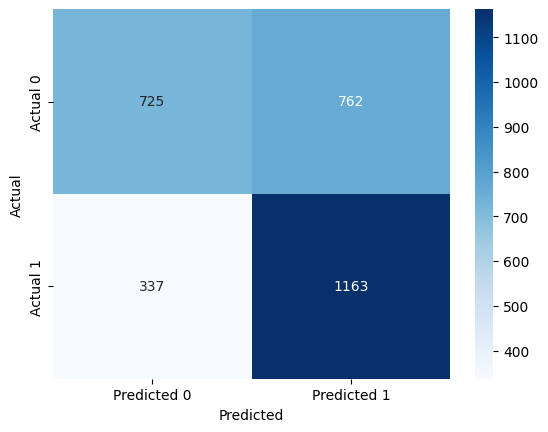

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# kNN with W2vect

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

#knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model=KNeighborsClassifier(
    n_neighbors=1,      # Number of neighbors to consider (default is 5, but set to 1 in your case)
    weights='uniform',  # All neighbors have equal weight ('distance' would weigh closer neighbors more)
    algorithm='auto',   # Chooses the best algorithm based on data ('ball_tree', 'kd_tree', or 'brute' can be set manually)
    leaf_size=30,       # Affects 'ball_tree' and 'kd_tree' algorithms (ignored for 'brute')
    p=2,                # Power parameter for Minkowski distance (p=2 corresponds to Euclidean distance, p=1 is Manhattan)
    metric='minkowski', # Default distance metric (with p=2, this is Euclidean distance)
    metric_params=None, # No additional parameters for the metric
    n_jobs=None         # No parallel processing (set to -1 to use all CPU cores)
)

knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)


# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.4206896551724138
Class 0 - Precision: 0.6108821104699094, Recall: 0.49831876260928043, F1-score: 0.5488888888888889
Class 1 - Precision: 0.5794813979706878, Recall: 0.6853333333333333, F1-score: 0.6279780085522297


## kNN Overall Performance

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Train K-Nearest Neighbors model
#knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model=KNeighborsClassifier(
    n_neighbors=1,      # Number of neighbors to consider (default is 5, but set to 1 in your case)
    weights='uniform',  # All neighbors have equal weight ('distance' would weigh closer neighbors more)
    algorithm='auto',   # Chooses the best algorithm based on data ('ball_tree', 'kd_tree', or 'brute' can be set manually)
    leaf_size=30,       # Affects 'ball_tree' and 'kd_tree' algorithms (ignored for 'brute')
    p=2,                # Power parameter for Minkowski distance (p=2 corresponds to Euclidean distance, p=1 is Manhattan)
    metric='minkowski', # Default distance metric (with p=2, this is Euclidean distance)
    metric_params=None, # No additional parameters for the metric
    n_jobs=None         # No parallel processing (set to -1 to use all CPU cores)
)

knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


Overall Precision: 0.5794813979706878
Overall Recall: 0.6853333333333333
Overall F1-score: 0.6279780085522297
Overall Accuracy: 0.5922330097087378


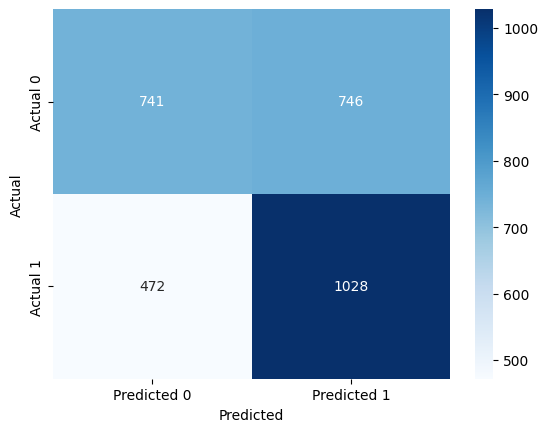

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

#lg_model = LogisticRegression(C=5, penalty='l1', solver='liblinear')
lg_model=LogisticRegression(
    penalty='l2',      # Default is L2 regularization (Ridge)
    dual=False,        # Dual formulation is only used when `penalty='l2'` and the number of samples > number of features
    tol=1e-4,          # Tolerance for stopping criteria
    C=1.0,             # Inverse of regularization strength (1.0 means moderate regularization)
    fit_intercept=True,# Whether to include an intercept term
    intercept_scaling=1, # Only relevant for `solver='liblinear'`
    class_weight=None, # No class weighting by default
    random_state=None, # No fixed randomness
    solver='lbfgs',    # Default solver (good for most cases, but does not support `l1` penalty)
    max_iter=100,      # Maximum number of iterations for convergence
    multi_class='auto',# Automatically chooses between 'ovr' (one-vs-rest) and 'multinomial'
    verbose=0,         # No verbosity (silent mode)
    warm_start=False,  # Whether to reuse previous solution for faster convergence
    n_jobs=None,       # No parallelization (only relevant for solvers like 'saga' or 'lbfgs')
    l1_ratio=None      # Only used if `penalty='elasticnet'`
)
lg_model = lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)


# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}')

Overall Accuracy: 0.4994979919678715
Class 0 - Precision: 0.6653171390013495, Recall: 0.6630800268997983, F1-score: 0.6641966992253284
Class 1 - Precision: 0.667109634551495, Recall: 0.6693333333333333, F1-score: 0.6682196339434276


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## LG Overall Performance

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Train Logistic Regression model
#lg_model = LogisticRegression(C=5, penalty='l1', solver='liblinear')
lg_model=LogisticRegression(
    penalty='l2',      # Default is L2 regularization (Ridge)
    dual=False,        # Dual formulation is only used when `penalty='l2'` and the number of samples > number of features
    tol=1e-4,          # Tolerance for stopping criteria
    C=1.0,             # Inverse of regularization strength (1.0 means moderate regularization)
    fit_intercept=True,# Whether to include an intercept term
    intercept_scaling=1, # Only relevant for `solver='liblinear'`
    class_weight=None, # No class weighting by default
    random_state=None, # No fixed randomness
    solver='lbfgs',    # Default solver (good for most cases, but does not support `l1` penalty)
    max_iter=100,      # Maximum number of iterations for convergence
    multi_class='auto',# Automatically chooses between 'ovr' (one-vs-rest) and 'multinomial'
    verbose=0,         # No verbosity (silent mode)
    warm_start=False,  # Whether to reuse previous solution for faster convergence
    n_jobs=None,       # No parallelization (only relevant for solvers like 'saga' or 'lbfgs')
    l1_ratio=None      # Only used if `penalty='elasticnet'`
)
lg_model = lg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lg_model.predict(X_test)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


Overall Precision: 0.667109634551495
Overall Recall: 0.6693333333333333
Overall F1-score: 0.6682196339434276
Overall Accuracy: 0.6662202879142953


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


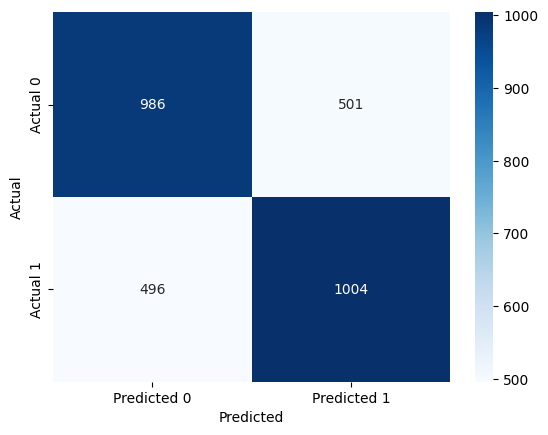

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Decison Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

#dt_model = DecisionTreeClassifier()
dt_model=DecisionTreeClassifier(
    criterion='gini',          # Splitting criterion ('gini' for Gini impurity, or 'entropy' for information gain)
    splitter='best',           # Chooses the best split at each node ('random' selects a random split)
    max_depth=None,            # No depth limit (tree grows until all leaves are pure or min_samples_split is reached)
    min_samples_split=2,       # Minimum samples required to split an internal node
    min_samples_leaf=1,        # Minimum samples required to be a leaf node
    min_weight_fraction_leaf=0.0, # Minimum weighted fraction of total samples required in a leaf node
    max_features=None,         # No limit on the number of features considered for the best split
    random_state=None,         # No fixed randomness by default
    max_leaf_nodes=None,       # No limit on the number of leaf nodes
    min_impurity_decrease=0.0, # A node splits if it decreases impurity by at least this amount
    class_weight=None,         # No class weighting by default
    ccp_alpha=0.0              # Complexity parameter for pruning (0 means no pruning)
)
dt_model = dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)



# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}')

Overall Accuracy: 0.4298707515557683
Class 0 - Precision: 0.6010928961748634, Recall: 0.5917955615332885, F1-score: 0.5964079972890546
Class 1 - Precision: 0.6014445173998687, Recall: 0.6106666666666667, F1-score: 0.6060205094277208


Confusion Matrix for DT Model :
Display the matrix with TP, TN, FP, FN counts.
https://chatgpt.com/share/2f5dfec4-026c-4017-944e-7720f539930f

## DT Overall Performance

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Train Decision Tree model
#dt_model = DecisionTreeClassifier()
dt_model=DecisionTreeClassifier(
    criterion='gini',          # Splitting criterion ('gini' for Gini impurity, or 'entropy' for information gain)
    splitter='best',           # Chooses the best split at each node ('random' selects a random split)
    max_depth=None,            # No depth limit (tree grows until all leaves are pure or min_samples_split is reached)
    min_samples_split=2,       # Minimum samples required to split an internal node
    min_samples_leaf=1,        # Minimum samples required to be a leaf node
    min_weight_fraction_leaf=0.0, # Minimum weighted fraction of total samples required in a leaf node
    max_features=None,         # No limit on the number of features considered for the best split
    random_state=None,         # No fixed randomness by default
    max_leaf_nodes=None,       # No limit on the number of leaf nodes
    min_impurity_decrease=0.0, # A node splits if it decreases impurity by at least this amount
    class_weight=None,         # No class weighting by default
    ccp_alpha=0.0              # Complexity parameter for pruning (0 means no pruning)
)
dt_model = dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


Overall Precision: 0.6075522589345921
Overall Recall: 0.6006666666666667
Overall F1-score: 0.6040898424404961
Overall Accuracy: 0.6046200200870439


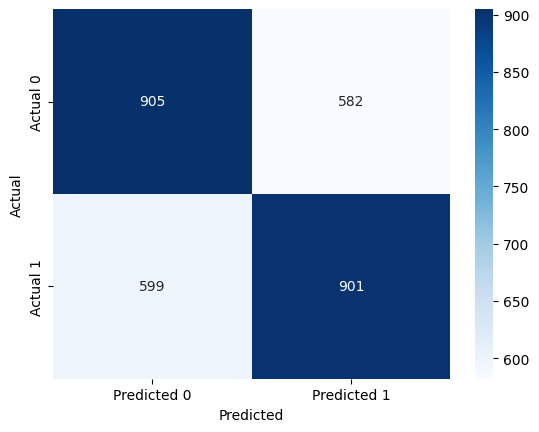

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

#svm_model = LinearSVC()
svm_model =LinearSVC(
    penalty='l2',       # Uses L2 regularization by default
    loss='squared_hinge', # Loss function (squared hinge loss for better optimization)
    dual=True,          # Uses dual formulation when n_samples > n_features
    tol=1e-4,           # Tolerance for stopping criteria
    C=1.0,              # Regularization strength (inverse of lambda)
    multi_class='ovr',  # One-vs-Rest (OvR) for multi-class classification
    fit_intercept=True, # Includes an intercept term
    intercept_scaling=1,# Scaling factor for intercept (only when fit_intercept=True)
    class_weight=None,  # No class weighting by default
    verbose=0,          # No logging output
    random_state=None,  # No fixed randomness
    max_iter=1000       # Maximum number of iterations for convergence
)
svm_model = svm_model.fit(X_train, y_train)

# Compute predictions
y_pred = svm_model.predict(X_test)


# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}')

Overall Accuracy: 0.5306174737381502
Class 0 - Precision: 0.6932972241029113, Recall: 0.6886348352387357, F1-score: 0.6909581646423751
Class 1 - Precision: 0.6933774834437086, Recall: 0.698, F1-score: 0.6956810631229235


## SVM Overall Performance

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train SVM model
#svm_model = LinearSVC()
svm_model =LinearSVC(
    penalty='l2',       # Uses L2 regularization by default
    loss='squared_hinge', # Loss function (squared hinge loss for better optimization)
    dual=True,          # Uses dual formulation when n_samples > n_features
    tol=1e-4,           # Tolerance for stopping criteria
    C=1.0,              # Regularization strength (inverse of lambda)
    multi_class='ovr',  # One-vs-Rest (OvR) for multi-class classification
    fit_intercept=True, # Includes an intercept term
    intercept_scaling=1,# Scaling factor for intercept (only when fit_intercept=True)
    class_weight=None,  # No class weighting by default
    verbose=0,          # No logging output
    random_state=None,  # No fixed randomness
    max_iter=1000       # Maximum number of iterations for convergence
)
svm_model = svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Compute overall metrics (precision, recall, f1-score) using 'binary' for 2-class problem
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')  # Use 'binary' for 2-class problem

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


Overall Precision: 0.6933774834437086
Overall Recall: 0.698
Overall F1-score: 0.6956810631229235
Overall Accuracy: 0.6933377971208571


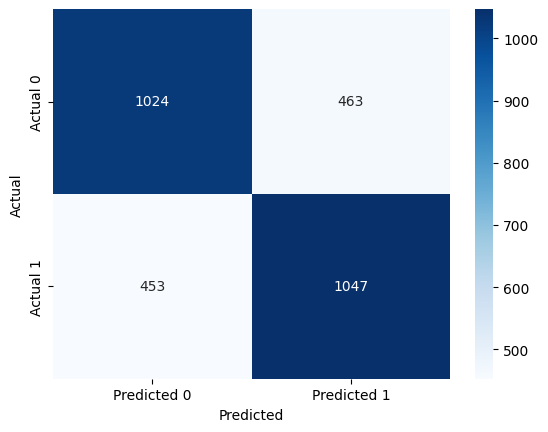

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()